In [ ]:
# working to do the zombies networks model

In [1]:
%matplotlib inline

import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import pause
import networkx as nx
import matplotlib as mt
import graphviz
from networkx import graphviz_layout
import pydot
import pylab

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# in case you want to name your people
#http = urllib3.PoolManager()
#names = http.request('GET', 'http://deron.meranda.us/data/census-derived-all-first.txt')

# want to start assigning ppl value so fighting may actually be worth it
# ie, if you fight, you can split the value of the ppl you kill
# if you join, they keep their shit

# should make babies not useful -- needs to take some number of rounds for them to grow up

# should make human/zombie strength an input

# want to animate the graph so you can see what happens at each step

# for some reason the crews are not actually disjoint

In [27]:
def start( n, pr ):
    # clears graph and starts a new one
    # n people, with pr probability of getting infected at stage 1
    # needs error handling for probability between 0 and 1, though this will get caught by python
    
    global G; global c; global zom; global hum
    
    hum = []; zom = []; c = []
    
    try:G.clear()
    except: print("no error: nothing to clear")

    # generate your starting graph
    G=nx.Graph()
    
    k = 1
    while k <= n:
        #randomly make a node human or zombie
        G.add_node(k, state = np.random.choice(['zombie','human'], p=[pr,1-pr])) 

        # if it's human, collect it, color it blue and connect it to humans
        if G.node[k]['state']=='human':
            hum.append(k)
            c.append('blue')
            G.add_edge(k, np.random.choice(hum))

        # if it's a zombie, collect it, color it red and connect it to zombies    
        else:
            zom.append(k)
            c.append('red')
            G.add_edge(k, np.random.choice(zom))
        k +=1

In [28]:
def begin_round( n ):
    global game; global e1; global e2; global crew2; global l2; global crew1; global l1; global G
    e1 = np.random.choice(G.nodes())
    e2 = np.random.choice(G.nodes())
    for i in list(nx.connected_components(G)):
        if e1 in i: crew1 = i; l1 = len(i)
    for i in list(nx.connected_components(G)):
        if e2 in i: crew2 = i; l2 = len(i)
    if G.node[e2]['state'] == G.node[e1]['state']:
        if G.node[e2]['state'] == 'human': game = 1 # human - human 
        else: game = 0; G.add_edge(e1,e2) #zombie herd grows, no other action
    else: game = 2 # zombie to human encounter

In [80]:
def human_fight( k, l1, l2, crew1, crew2, e2, e1 ):
    global G
    if crew1 == crew2:
        if np.random.rand() > .8:
            b = max(G.nodes())+1
            G.add_node(b, state = 'human')
            G.add_edge(b,e1)
            G.add_edge(b,e2)
            print("round %d. love wins, baby %d born"%(k, b))
            G.add_edge(e1,e2)
        else:
            G.add_edge(e1,e2)
    else:
        dec = input("fight, flee or join?")

        if dec == "fight":
            print("round %d. you said fight, so we're fighting. its the %d of you against %d"%(k, l1, l2))
            for nd in crew1:
                #your ppl can die
                try: 
                    G.node[nd]["state"]
                    if .5*l1 - .5*l2 + np.random.normal() < -0.7:
                        print("round %d. your buddy human %d is dead"%(k, nd))
                        G.node[nd]["state"] = 'dead' # person nd is dead
                    else: G.add_edge(nd,e2) #whoever doesn't die, joins
                except: pass

            for nd in crew2:
                # their people can die
                try: 
                    G.node[nd]["state"]
                    if  .5*l1 - .5*l2 + np.random.normal() > 0.7:
                        print("round %d. that loser human %d is dead"%(k, nd))
                        G.node[nd]["state"] = 'dead' # person is dead
                    else: G.add_edge(nd,e1)
                except: pass

        elif dec == "join": 
            print("round %d. yea! further the human project!"%(k))
            if np.random.rand() > .8:
                b = max(G.nodes())+1
                G.add_node(b, state = 'human')
                G.add_edge(b,e1)
                G.add_edge(b,e2)
                print("round %d. love wins, baby %d born"%(k, b))
                G.add_edge(e1,e2)
            else:
                G.add_edge(e1,e2)

        else: print("round %d. successful fleeing"%(k))

In [98]:
def zombie_fight(k,l2,l1,crew1,crew2,e2,e1):
    global G
    if G.node[e1]['state'] == 'human': hs = l1; zs = l2; hcrew = crew1; zcrew = crew2
    else: hs = l2; zs = l1; hcrew = crew2; zcrew = crew1
    print("round %d. %d zombies attacking %d humans"%(k, zs, hs))
    # see what happens to the humans: roll a die for each person in human group
    for nd in hcrew:
        try: 
            G.node[nd]["state"]
            if  -.4*hs + .1*zs + np.random.normal() > 0.7:
                print("round %d. human %d infected"%(k, nd))
                G.node[nd]['state'] = 'zombie' # person is a zombie
                G.remove_edges_from(G.edges(nd)) # person disconnected from all humans
                G.add_edge(nd,zcrew.pop()) # person joins zombie herd
            elif -.6*hs + .1*zs + np.random.rand() > 0.7:
                print("round %d. human %d dead"%(k, nd))
                G.node[nd]["state"] = 'dead' # person is dead
        except: pass
            
    # see what happens to the zombies
    for nd in zcrew:
        try: 
            G.node[nd]["state"]
            if .5 - 0.1*zs + .1*hs + np.random.normal() > 1:
                print("round %d. zombie %d killed"%(k, nd))
                G.node[nd]["state"] = 'dead' # zombie is dead
        except: pass

In [31]:
def clean_up():
    global G; global c
    c = []
    for i in G.nodes():
        try: 
            if G.node[i]['state'] == 'dead': G.remove_node(i)
            elif G.node[i]['state'] == 'human': c.append('blue')
            elif G.node[i]['state'] == 'zombie':c.append('red')
        except:
            G.remove_node(i)

In [32]:
def get_fig(G,c):
    # would lik to figure out how to animate this as you go
    nx.draw(G, node_color = c, with_labels = True, node_size = 500)

In [149]:
def apocalypse( rounds, n, pr ):
    start( n, pr )
    global k
    k = 1
    while k <= rounds:
        begin_round( n )
        if game == 1: human_fight(   k, l1, l2, crew1, crew2, e2, e1 )
        elif game == 2: zombie_fight( k,l2,l1,crew1,crew2,e2,e1 )
        else: pass
        clean_up()
        k+=1
    get_fig(G,c)

round 6. 32 zombies attacking 2 humans
round 6. human 34 infected
round 6. human 50 infected
round 9. 34 zombies attacking 9 humans
round 9. human 33 infected
round 13. 40 zombies attacking 1 humans
round 13. human 47 infected
round 14. 41 zombies attacking 7 humans
round 14. human 32 infected
round 14. human 35 infected
round 14. human 36 infected
round 14. human 42 infected
round 14. human 12 infected
round 14. human 13 infected
round 17. 48 zombies attacking 1 humans
round 17. human 49 infected


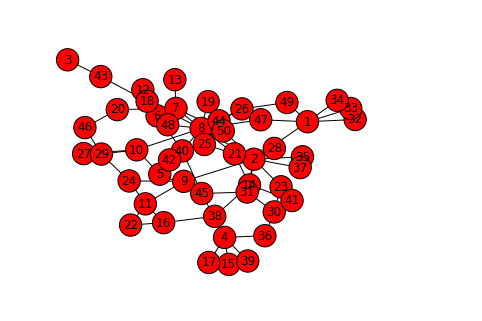

In [152]:
apocalypse(30, 50, .8)

In [ ]:
#Can run step by step here:

In [108]:
start(40,.7)

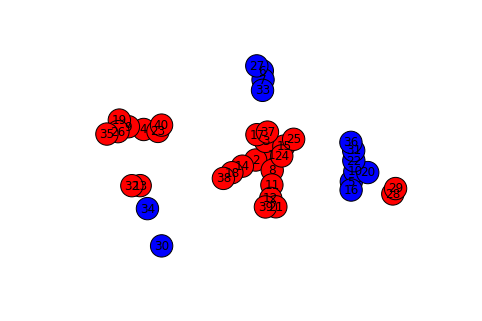

In [109]:
nx.draw(G, node_color = c, with_labels = True, node_size = 500)

In [146]:
begin_round(1)
k = 1
game

2

In [132]:
crew1

{5, 16}

In [147]:
#if game is 2, do a zombie fight
zombie_fight(k,l2,l1,crew1,crew2,e2,e1)

round 1. 31 zombies attacking 1 humans
round 1. human 33 infected


In [81]:
#if game is 1, do a human fight
human_fight(  k, l1, l2, crew1, crew2, e2, e1 )

In [144]:
clean_up()

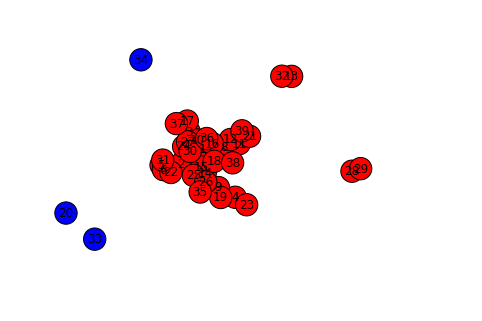

In [145]:
nx.draw(G, node_color = c, with_labels = True, node_size = 500)

In [38]:
G.edges()

[(1, 1),
 (1, 2),
 (1, 11),
 (1, 5),
 (1, 33),
 (2, 39),
 (3, 15),
 (3, 9),
 (3, 3),
 (3, 30),
 (3, 7),
 (4, 4),
 (5, 10),
 (5, 22),
 (5, 31),
 (6, 8),
 (6, 6),
 (7, 27),
 (7, 13),
 (7, 23),
 (8, 16),
 (8, 38),
 (9, 28),
 (10, 17),
 (10, 26),
 (11, 34),
 (11, 20),
 (11, 14),
 (12, 12),
 (13, 35),
 (13, 29),
 (14, 37),
 (16, 18),
 (17, 17),
 (17, 19),
 (18, 32),
 (20, 21),
 (22, 24),
 (23, 25),
 (24, 33),
 (27, 40),
 (27, 39),
 (29, 36)]